In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional
from keras.regularizers import l2, l1
import numpy as np
from readdata import read_data
import collections
from keras.models import load_model
from keras import optimizers
from keras import metrics

x_train, y_train, x_text, y_test = read_data(level=0, length_limit=350)
# x_train = x_train * 5
# y_train = y_train * 5

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
targets = set()
for i, (input_text, target) in enumerate(zip(x_train, y_train)):
    input_texts.append(input_text)
    target_texts.append(target)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    if target not in targets:
        targets.add(target)

input_characters = sorted(list(input_characters))
targets = sorted(list(targets))
num_encoder_tokens = len(input_characters)
nb_targets = len(targets)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output classes:', nb_targets)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('Class counts:', [(key, value) for
                        key, value in (collections.Counter(y_train)).iteritems()])

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(targets)])

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_index = dict(
    (i, char) for char, i in target_token_index.items())



encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
y_encoded = np.zeros((len(input_texts), nb_targets), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, -(t+1), input_token_index[char]] = 1.
    y_encoded[i, target_token_index[target_text]] = 1.
    

('Missing proteins: ', 174856)
('All count: ', 184939)
('Number of samples:', 3690)
('Number of unique input tokens:', 21)
('Number of unique output classes:', 6)
('Max sequence length for inputs:', 350)
('Max sequence length for outputs:', 1)
('Class counts:', [('1', 857), ('3', 1028), ('2', 717), ('5', 85), ('4', 313), ('6', 690)])


In [2]:
""" No pre-training """

batch_size = 128  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 32  # Latent dimensionality of the encoding space.

encoder_inputs = Input(shape=(None, num_encoder_tokens))
# mask_1 = Masking(mask_value=0.0)(encoder_inputs)
encoder_1 = LSTM(latent_dim, return_sequences=False)(encoder_inputs)
# encoder_2 = Bidirectional(LSTM(latent_dim, return_sequences=False,  
#                                W_regularizer=l2(0.004)))(encoder_1)
# encoder_2 = LSTM(latent_dim*2,  W_regularizer=l2(0.001), recurrent_dropout=0.3)(encoder_1)
# encoder_states = [state_h, state_c]
dense_1 = Dense(64, activation='relu')(encoder_1)
dropout_1 = Dropout(0.50)(dense_1)
# dense_2 = Dense(128, activation='relu')(dropout_1)
# dropout_2 = Dropout(0.50)(dense_1)
dense_outputs = Dense(nb_targets, activation='softmax')(dropout_1)

model = Model(encoder_inputs, dense_outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 21)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6912      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 9,414
Trainable params: 9,414
Non-trainable params: 0
_________________________________________________________________


In [15]:
""" Load pre-trained encoder """

ed_model = load_model('checkpoints/encoder-decoder-model.hdf5')
ed_model.summary()


dense_1 = Dense(1024, activation='relu')(ed_model.layers[2].output[0])
dropout_1 = Dropout(0.50)(dense_1)
dense_2 = Dense(1024, activation='relu')(dropout_1)
dropout_2 = Dropout(0.50)(dense_2)
dense_outputs = Dense(nb_targets, activation='softmax')(dropout_2)

model = Model(ed_model.layers[0].input, dense_outputs)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, None, 21)      0                                            
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, None, 23)      0                                            
____________________________________________________________________________________________________
lstm_13 (LSTM)                   [(None, 32), (None, 3 6912        input_13[0][0]                   
____________________________________________________________________________________________________
lstm_14 (LSTM)                   [(None, None, 32), (N 7168        input_14[0][0]                   
                                                                   lstm_13[0][1]           

In [16]:
# freeze encoder
model.layers[0].trainable = False
model.layers[1].trainable = False

In [17]:
# Run training

batch_size = 128  # Batch size for training.
epochs = 200  # Number of epochs to train for.
# latent_dim = 32  # Latent dimensionality of the encoding space.

sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
adadlt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(encoder_input_data, y_encoded,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          verbose=1)

print "TRAINING COMPLETED"

Train on 2952 samples, validate on 738 samples
Epoch 1/200
2952/2952 [==============================] - 4s - loss: 1.3415 - acc: 0.4377 - val_loss: 3.9789 - val_acc: 0.0000e+00
Epoch 2/200
2952/2952 [==============================] - 4s - loss: 1.1367 - acc: 0.5383 - val_loss: 4.0057 - val_acc: 0.0244
Epoch 3/200
2952/2952 [==============================] - 4s - loss: 1.0426 - acc: 0.6006 - val_loss: 4.0280 - val_acc: 0.1436
Epoch 4/200
2952/2952 [==============================] - 4s - loss: 1.0382 - acc: 0.5982 - val_loss: 4.0412 - val_acc: 0.0989
Epoch 5/200
2952/2952 [==============================] - 4s - loss: 0.9977 - acc: 0.6209 - val_loss: 4.0364 - val_acc: 0.1165
Epoch 6/200
2952/2952 [==============================] - 4s - loss: 0.9830 - acc: 0.6196 - val_loss: 4.3127 - val_acc: 0.1138
Epoch 7/200
2952/2952 [==============================] - 4s - loss: 0.9674 - acc: 0.6264 - val_loss: 3.9826 - val_acc: 0.1518
Epoch 8/200
2952/2952 [==============================] - 4s - loss:

2952/2952 [==============================] - 4s - loss: 0.7016 - acc: 0.7280 - val_loss: 5.5879 - val_acc: 0.1843
Epoch 66/200
2952/2952 [==============================] - 4s - loss: 0.7197 - acc: 0.7182 - val_loss: 5.4202 - val_acc: 0.1816
Epoch 67/200
2952/2952 [==============================] - 4s - loss: 0.7020 - acc: 0.7388 - val_loss: 5.7483 - val_acc: 0.1721
Epoch 68/200
2952/2952 [==============================] - 4s - loss: 0.6912 - acc: 0.7314 - val_loss: 5.4515 - val_acc: 0.1545
Epoch 69/200
2952/2952 [==============================] - 4s - loss: 0.6881 - acc: 0.7314 - val_loss: 5.7487 - val_acc: 0.1518
Epoch 70/200
2952/2952 [==============================] - 4s - loss: 0.6930 - acc: 0.7381 - val_loss: 5.6076 - val_acc: 0.1694
Epoch 71/200
2952/2952 [==============================] - 4s - loss: 0.6882 - acc: 0.7358 - val_loss: 5.7450 - val_acc: 0.1599
Epoch 72/200
2952/2952 [==============================] - 4s - loss: 0.6847 - acc: 0.7402 - val_loss: 5.7530 - val_acc: 0.15

2952/2952 [==============================] - 4s - loss: 0.6046 - acc: 0.7656 - val_loss: 6.0823 - val_acc: 0.1680
Epoch 130/200
2952/2952 [==============================] - 4s - loss: 0.6378 - acc: 0.7581 - val_loss: 6.0956 - val_acc: 0.1667
Epoch 131/200
2952/2952 [==============================] - 4s - loss: 0.5992 - acc: 0.7690 - val_loss: 6.0308 - val_acc: 0.1680
Epoch 132/200
2952/2952 [==============================] - 4s - loss: 0.6128 - acc: 0.7707 - val_loss: 5.9201 - val_acc: 0.1721
Epoch 133/200
2952/2952 [==============================] - 4s - loss: 0.6045 - acc: 0.7683 - val_loss: 5.9538 - val_acc: 0.1829
Epoch 134/200
2952/2952 [==============================] - 4s - loss: 0.6069 - acc: 0.7605 - val_loss: 5.9929 - val_acc: 0.1707
Epoch 135/200
2952/2952 [==============================] - 4s - loss: 0.6229 - acc: 0.7605 - val_loss: 5.9186 - val_acc: 0.1734
Epoch 136/200
2952/2952 [==============================] - 4s - loss: 0.6179 - acc: 0.7649 - val_loss: 5.9642 - val_ac

2952/2952 [==============================] - 4s - loss: 0.6054 - acc: 0.7734 - val_loss: 6.1658 - val_acc: 0.1816
Epoch 194/200
2952/2952 [==============================] - 4s - loss: 0.5776 - acc: 0.7791 - val_loss: 6.2970 - val_acc: 0.1789
Epoch 195/200
2952/2952 [==============================] - 4s - loss: 0.5637 - acc: 0.7883 - val_loss: 6.2645 - val_acc: 0.1626
Epoch 196/200
2952/2952 [==============================] - 4s - loss: 0.5554 - acc: 0.7893 - val_loss: 6.4514 - val_acc: 0.1626
Epoch 197/200
2952/2952 [==============================] - 3s - loss: 0.5528 - acc: 0.7846 - val_loss: 6.4689 - val_acc: 0.1789
Epoch 198/200
2952/2952 [==============================] - 4s - loss: 0.5568 - acc: 0.7808 - val_loss: 6.4720 - val_acc: 0.1707
Epoch 199/200
2952/2952 [==============================] - 4s - loss: 0.5966 - acc: 0.7690 - val_loss: 6.2345 - val_acc: 0.1748
Epoch 200/200
2952/2952 [==============================] - 4s - loss: 0.5724 - acc: 0.7879 - val_loss: 6.2961 - val_ac

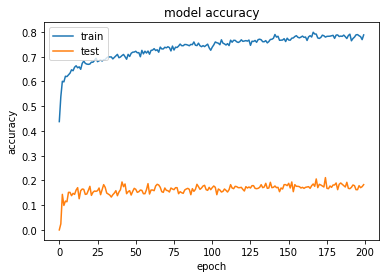

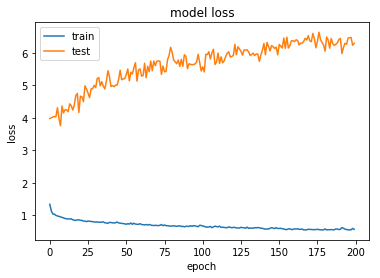

In [18]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()